In [15]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
train_x = torch.stack([torch.linspace(0, 1, 100),
torch.linspace(0, 2, 100)
],-1)
train_x1 = torch.linspace(0, 1, 100)

print(0)
train_y = torch.stack([
    torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    torch.sin(train_x1 * (2 * math.pi)) + 2 * torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
    -torch.cos(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2,
], -1)

print(train_x.shape, train_y.shape)

0
torch.Size([100, 2]) torch.Size([100, 4])


In [17]:
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel

In [12]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=4
        )
        self.base_covar_module =  gpytorch.kernels.MultitaskKernel(ScaleKernel(RBFKernel()), num_tasks=4, rank=2
        )
        # self.base_covar_module = ScaleKernel(RBFKernel())

        # # self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:500, :], likelihood=likelihood)
        # self.covar_module = gpytorch.kernels.MultitaskKernel(
        #     gpytorch.kernels.InducingPointKernel(self.base_covar_module, inducing_points=train_x[:50, :], likelihood=likelihood), num_tasks=4, rank=2
        # )
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.InducingPointKernel(self.base_covar_module, inducing_points=train_x[:50, :], likelihood=likelihood))
        # self.covar_module = gpytorch.kernels.MultitaskKernel(
        #     gpytorch.kernels.RBFKernel(), num_tasks=4, rank=2
        # )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=4)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [13]:
# class GPModel(ApproximateGP):
#     def __init__(self, inducing_points):
#         variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
#         variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
#         super(GPModel, self).__init__(variational_strategy)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# inducing_points = train_x[:500, :]
# model = GPModel(inducing_points=inducing_points)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [14]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# print(0)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    # print(0)
    loss = -mll(output, train_y)
    # print(0)
    # print(loss)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

IndexError: tuple index out of range

torch.Size([51, 2])


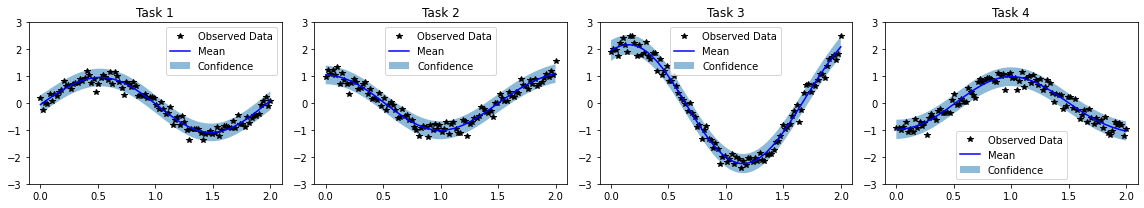

In [25]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.stack([ torch.linspace(0, 1, 51),
    torch.linspace(0, 2, 51)],-1)
    print(test_x.shape)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x[:,1].detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x[:,1].numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x[:,1].numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None